<a href="https://colab.research.google.com/github/kaleetock/clusters/blob/main/DoubleStarSetup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Authorize Google Drive and Install Modules
!pip install astroquery
!pip install astropy
!pip install --upgrade gspread
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import astroquery.gaia
import astropy.units as u
import astropy.coordinates
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
import os
import re
import math
import bokeh.plotting as bk
import matplotlib as mpl
from bokeh.models import Range1d, Label
from bokeh.layouts import row, gridplot
from scipy import stats
import numpy as np
from astropy.io import fits

In [7]:
#@title Load Stars from Spreadsheet

##########################################

def cn (num):
  m = re.search(r"^\s*(\d+\.?\d*)\s*$", num)
  if m:
    return float(m.group(1))
  else:
    return float('nan')

##########################################

def parse_row(r):
  (name, WDS, Disc, coord, PA, sep, mag1, mag2, plx1, plx2, plx_e1, plx_e2, pmra1, 
  pmra2, pmra_e1, pmra_e2, pmdec1, pmdec2, pmdec_e1, pmdec_e2, rv1,	rv2, rv_e1,	
  rv_e2, b_r1, b_r2, g1, g2) = (r[0], r[1], r[2], r[3], cn(r[4]), cn(r[5]), cn(r[6]), 
  cn(r[7]), cn(r[8]), cn(r[9]), cn(r[10]), cn(r[11]), cn(r[12]), cn(r[13]), cn(r[14]), 
  cn(r[15]), cn(r[16]), cn(r[17]), cn(r[18]), cn(r[19]), cn(r[20]), cn(r[21]), 
  cn(r[22]), cn(r[23]), cn(r[24]), cn(r[25]), cn(r[26]), cn(r[27]))

  mPA, msep = 0, 0

  if len(r) > 28:
    (mPA, msep) = (r[28], r[29])

  return(name, WDS, Disc, coord, PA, sep, mag1, mag2, plx1, plx2, plx_e1, plx_e2, pmra1, 
  pmra2, pmra_e1, pmra_e2, pmdec1, pmdec2, pmdec_e1, pmdec_e2, rv1,	rv2, rv_e1,	
  rv_e2, b_r1, b_r2, g1, g2, mPA, msep)

##########################################

def get_stars(spreadsheet, datadir):
  stars, stus = [], {}
  worksheet = gc.open(spreadsheet).sheet1
  rows = worksheet.get_all_values()
  row_count = 0
  for r in rows:
    row_count += 1
    if (row_count <= 2):
      continue

    (name, WDS, Disc, coord, PA, sep, mag1, mag2, plx1, plx2, plx_e1, plx_e2, pmra1, 
    pmra2, pmra_e1, pmra_e2, pmdec1, pmdec2, pmdec_e1, pmdec_e2, rv1,	rv2, rv_e1,	
    rv_e2, b_r1, b_r2, g1, g2, mPA, msep) = parse_row(r)

    Disc = Disc.replace(" ", "") 
    WDS = WDS.replace(" ", "") 
    c = SkyCoord(coord, frame='icrs', unit=(u.hourangle, u.deg))

    m = re.search(r"^\s*(\w+)\s*(\d+)\s*$", name)
    if m:
      stu, num = m.group(1), int(m.group(2))
    else:
      print(f"row {r} doesn't match!")

    star = {"student": stu, "num": num, "WDS": WDS, "Disc": Disc, "text_coord": coord, 
            "PA": PA, "sep": sep, "mag1": mag1, "mag2": mag2, "plx1": plx1, "plx2": plx2, 
            "plx_e1": plx_e1, "plx_e2": plx_e2, "pmra1": pmra1, "pmra2": pmra2, 
            "pmra_e1": pmra_e1, "pmra_e2": pmra_e2, "pmdec1": pmdec1, "pmdec2": pmdec2, 
            "pmdec_e1": pmdec_e1, "pmdec_e2": pmdec_e2, "rv1": rv1, "rv2": rv2, 
            "rv_e1": rv_e1, "rv_e2": rv_e2, "b_r1": b_r1, "b_r2": b_r2, "g1": g1, 
            "g2": g2, "coord": c, "wds_path": "", "Gaia_data": False, "mPA": mPA, "msep": msep}

    p = os.path.join(datadir,"wds"+WDS+".txt")
    if os.path.isfile(p):
#      print(f"Found {stu} {num} star")
      star["wds_path"] = p
    else:
      print(f"*** Did not find {stu} {num} {WDS} historical data")

    if stu not in stus.keys():
      stus[stu] = {}

    stus[stu][num] = star
    stars.append(star)

  return(stars, stus)

##########################################

def find_imgs(WDS, Disc, imgdir):
#  print(f"Looking for {WDS[0:5]}")
  return("")
  imgdirs = [f for f in sorted(os.listdir(imgdir)) if os.path.isdir(os.path.join(imgdir, f))]

  for d in imgdirs:
    m = re.search(WDS[0:5], d)
    if m:
      p = os.path.join(imgdir, d)
      imgs = [f for f in sorted(os.listdir(p)) if os.path.isfile(os.path.join(p, f))]
      num_imgs = len(imgs)
      exp_times, filts = {}, {}
      for img in imgs:
        img_path = os.path.join(p, img)
        hdul = fits.open(img_path)
        hdr = hdul[0].header
        exptime = hdr["EXPTIME"]
        filt = hdr["FILTER1"]
        exp = round(float(exptime))
        if exp not in exp_times.keys():
          exp_times[exp] = 1
        else:
          exp_times[exp] += 1
        if filt not in filts.keys():
          filts[filt] = 1
        else:
          filts[filt] += 1

      print(filts)
      return(exp_times)
    
##########################################

def show_stu_stars(stus, imgdir):
  summary_found, summary_missing = "", "" 
  for stu in sorted(stus.keys()):
    num_systems, systems = 0, ""
    stu_stars = stus[stu]
    for num in sorted(stu_stars.keys()):
      star = stus[stu][num]
      WDS, Disc = star["WDS"], star["Disc"]
      exp_times = find_imgs(WDS, Disc, imgdir)
      desc = Disc+str(f" {exp_times} ")
#      print(desc)
      systems = systems+desc
      description = str(f"\n\t{WDS} {Disc} ({stu} system {num})")
      if re.search(r"\w+", star["wds_path"]):
        num_systems += 1
      else:
        summary_missing += description
    summary_found += str(f"{stu[0:7]}\t{num_systems} systems: {systems}\n")

  print(f"Found historical data for: \n{summary_found}")
  if re.search(r"\w+", summary_missing):
    print(f"Missing stars: {summary_missing}")

##########################################

folder = "/content/drive/My Drive/2022 Astronomy Research Seminar/2022 Double Star Intro Project/" 
spreadsheet = "2022 Double Star Targets"
stars, stus = get_stars(spreadsheet, folder+"WDS Historical Data/")
print("\nSpreadsheet loaded.\n")
show_stu_stars(stus, folder+"Images/")


*** Did not find Jack 1 08242+6845 historical data
*** Did not find Jack 2 08248+6409 historical data
*** Did not find Jack 3 08419+6113 historical data
*** Did not find Elane 1 04367-5009 historical data
*** Did not find Elane 2 04367+4105 historical data
*** Did not find Elane 3 04552+1451 historical data
*** Did not find Sophia 1 08011-4013 historical data
*** Did not find Sophia 2 08019-0827 historical data
*** Did not find Sophia 3 08020+2532 historical data

Spreadsheet loaded.

Found historical data for: 
Adela	3 systems: STF589AB  DAM1323  BAL2621  
Aisha	3 systems: STF1259  STI601  STF1065  
Alex	3 systems: BRT40  DAM1261  STF2693  
Backup	5 systems: STF1634  HJ2617AB  STF1833AB  KPP3207  UC693  
Carolin	3 systems: STF790  STF766AB  STF688  
Elane	0 systems: HJ3671  STF563  HJ3262  
Ella	3 systems: SEI220AB  BRT299  HJ349  
Jack	0 systems: WFC68  ARG18  STI679  
Joey	3 systems: BPM90  HJ3969  GAL385  
Keshav	3 systems: SLE759  STF924AB  POU1448  
Sophia	0 systems: WG76  HJ773 

In [8]:
#@title Extract Historical Data from USNO files
# This cell extracts the data from the USNO files specified by the filenames
# and prints a summary below the cell when it is run. (A description of the
# printed summary appears at the bottom of the cell.)

########################################################################

def log_data (data, dates, PAs, seps, apertures, nns, methods, system_data):
  system_data["dates"] = dates
  system_data["PAs"] = PAs
  system_data["seps"] = seps
  system_data["apertures"] = apertures
  system_data["nns"] = nns
  system_data["methods"] = methods

  discoverer = system_data["discoverer"]
  discoverer = discoverer.replace(" ", "")

  n = int(len(dates))
  if ((n != int(len(PAs))) or (n != int(len(seps))) or (n != int(len(apertures))) or (n != int(len(nns))) or (n != int(len(methods)))):
    print ("PROBLEM!  Array lengths do not match for %s" % (discoverer))
    print ("\tdates length %d" % len(dates))
    print ("\tPAs length %d" % len(PAs))
    print ("\tseps length %d" % len(seps))
    print ("\tapertures length %d" % len(apertures))
    print ("\tnns length %d" % len(nns))
    print ("\tmethods length %d" % len(methods))

  else:
#    print ("Logging data for %s" % (discoverer))
    data[discoverer] = system_data

########################################################################

def read_data(wds_path, data):
  (dates, PAs, seps, apertures, nns, methods) = ([],[],[],[],[],[])
  discoverer = ""
  system_data = {}

  with open(wds_path, 'r') as f:
    for line in f:
      m2 = re.search( r'^\s\s\s\s\s\s\s(\d\d\d\d\.[\d]*)\s+q?(\d+\.\d*)\s[\s\d]+\.[\s\d]+\s(\d+\.\d*)', line)  # Make sure the line has both a PA and a sep
      if m2:
        (date, posang, s) = (float(m2.group(1)), float(m2.group(2)), m2.group(3))
        d = float(line[7:17].strip())
        PA = float(line[19:26].strip())
        sep = float(line[35:44].strip())
        aperture = line[92:97].strip()
        nn = line[99:101].strip()
        method = line[111:113].strip()
        flag = line[114]
        if (flag == "X"):      # An X code at the end of a line signifies an error; do not use that point.
          continue
        dates.append(d)
        PAs.append(PA)
        seps.append(sep)
        apertures.append(aperture)
        nns.append(nn)
        methods.append(method)

#        print("\t%s  \t%.3f\t%s\t%.2f\t%s\t%.2f\t%s\t%s\t%s" % (date,d, posang, PA, s, sep, aperture,nn, method))
      else:
        if len(line)>14 and (line[13] == "1" or line[13] == "2"):  # This signifies the header line for a new system in the file.
          first = line[13:17]
          last = line [18:22]

          if re.search(r'^\d\d\d\d$', first) and re.search(r'^\d\d\d\d$', last) and int(first)<int(last):
            if (len(dates)>0):
              log_data (data, dates, PAs, seps, apertures, nns, methods, system_data)
              (dates, PAs, seps, apertures, nns, methods) = ([],[],[],[],[],[])
            system_data = extract_system_header(line, first, last)

  f.close()
  log_data (data, dates, PAs, seps, apertures, nns, methods, system_data)

########################################################################

# This function extracts the data from the header line for a new system in a
# WDS historical data file.

def extract_system_header(line, first, last):
  system_data = {}
  (radeg, decdeg) = (0.0, 0.0)

  discoverer = line[0:12].strip()
#  print("discoverer %s" % discoverer)
  discoverer = discoverer.replace(" ", "")
  system_data["discoverer"] = discoverer
  system_data["first_obs_date"] = first
  system_data["last_obs_date"] = last

  num_pts = line[23:28]
  num_pts = int(num_pts.replace(" ", ""))

  wds_mag_pri = line[48:54]
  wds_mag_sec = line[54:60]
  wds_mag_pri = float(wds_mag_pri.replace(" ",""))
  wds_mag_sec = wds_mag_sec.replace(" ","")
  if (re.match('^\.$', wds_mag_sec)):
    wds_mag_sec = wds_mag_pri+1       # For very close doubles, sometimes the mag sec is not listed.  
                                      # In those cases, assume that mag sec is one magnitude dimmer than mag pri.
    print ("%s secondary magnitude unknown!  Mag pri = %.1f, assuming mag sec = %.1f." % (discoverer, wds_mag_pri, wds_mag_sec))
  else:
    wds_mag_sec = float(wds_mag_sec)
#  print("HEADER %s mag pri %.2f mag sec %.2f" % (line, wds_mag_pri, wds_mag_sec))

  pmra_pri = line[70:74]
  precise_coords = line[102:120]
  system_data["pmra_pri"] = pmra_pri

  m = re.match('^(\d\d)(\d\d)(\d\d\.\d+)([+-]\d\d)(\d\d)(\d\d\.\d+)$', precise_coords)
  if m:
    rah = m.group(1)
    ram = m.group(2)
    ras = m.group(3)
    decd = m.group(4)
    decm = m.group(5)
    decs = m.group(6)

    coord_str = (rah+"h"+ram+"m"+ras+"s"+decd+"d"+decm+"m"+decs+"s")
    coord = SkyCoord(coord_str)
    radeg = coord.ra.deg
    decdeg = coord.dec.deg
    system_data["coord_str"] = coord_str
    system_data["wds_coord"] = coord
    system_data["radeg"] = radeg
    system_data["decdeg"] = decdeg
    system_data["wds_mag_pri"] = wds_mag_pri
    system_data["wds_mag_sec"] = wds_mag_sec
  else:
    return(system_data)
    print("PROBLEM! coords %s do not match!" % coords)

#  print ("%s   \t%s\t%s\t%s\t%.2f\t%.2f\t%d" % (discoverer, first, last, pmra_pri, radeg, decdeg, num_pts))
  return(system_data)

########################################################################

def extract_WDS_data(stus, data):
  for stu in sorted(stus.keys()):
    stu_stars = stus[stu]
    for num in sorted(stu_stars.keys()):
      star = stus[stu][num]
      if re.search(r"\w+", star["wds_path"]):
        read_data(star["wds_path"], data)

########################################################################

data = {}
extract_WDS_data(stus, data)

sts = ""
for k in sorted(data.keys()):
  sts = sts + str(f"{k}, ")
print(sts)

for stu in sorted(stus.keys()):
  stu_stars = stus[stu]
  for num in sorted(stu_stars.keys()):
    star = stus[stu][num]
#    print(f"{stu} {num} {star}")
    if re.search(r"\w+", star["wds_path"]):
      discoverer = star["Disc"]
      PA = star["PA"]
      numpoints = len(data[discoverer]["dates"])
      star["hist_data"] = data[discoverer]
      print(f"{stu} system {num}: {discoverer}, {numpoints} data points") 

# This extracts data from the WDS files and prints the number of historical 
# data points it found for the each of the stars of interest.

ANT4AF, ANT4AG, ANT4EG, BAL2621, BKO114AD, BPM90, BRT299, BRT40, DAM1261, DAM1323, GAL385, GIC48, GWP612BC, HJ2617AB, HJ2617AC, HJ349, HJ3969, KPP3207, POU1448, POU504, SEI220AB, SEI222AC, SEI222BC, SHY28BC, SLE759, STF1065, STF1245AB, STF1245AC, STF1245AD, STF1245AE, STF1259, STF1634, STF1833AB, STF1833BC, STF2693, STF331, STF589AB, STF683, STF688, STF766AB, STF790, STF900AB, STF900AC, STF924AB, STF924BC, STI601, UC693, YSC186Aa,Ab, 
Adela system 1: STF589AB, 161 data points
Adela system 2: DAM1323, 10 data points
Adela system 3: BAL2621, 12 data points
Aisha system 1: STF1259, 33 data points
Aisha system 2: STI601, 12 data points
Aisha system 3: STF1065, 95 data points
Alex system 1: BRT40, 13 data points
Alex system 2: DAM1261, 16 data points
Alex system 3: STF2693, 30 data points
Backup system 1: STF1634, 38 data points
Backup system 2: HJ2617AB, 49 data points
Backup system 3: STF1833AB, 120 data points
Backup system 4: KPP3207, 4 data points
Backup system 5: UC693, 8 data points


In [9]:
#@title Look Up Stars in Gaia

# This cell performs the Gaia lookup for each star of interest (i.e. each star in 
# the "stars" dictionary), and inserts the Gaia measurements for the primary and 
# secondary stars into the "data" dictionary entry for that star.

########################################################################

def check_all_stars_in_field (PA, sep, mag1, mag2, r, name):
  (pps, pss) = ([], [])
  for star in r:
    if (abs(star["phot_g_mean_mag"] - mag2) < 2):    
      pss.append(star)
    if (abs(star["phot_g_mean_mag"] - mag1) < 2):
      pps.append(star)

  if (name=="STI2051AB"):  # STI2051AB has an imposter secondary in Gaia
    pss.pop(0)

  for potential_primary in pps:
    for potential_secondary in pss:
      if (potential_primary["dist"] == potential_secondary["dist"]):
        continue
      if(check_stars(PA, sep, mag1, mag2, potential_primary, potential_secondary)):
        (position_angle, separation, cp, cs) = Gaia_PA_sep(potential_primary, potential_secondary)
        return(True, potential_primary, potential_secondary) 

  print("ALL STARS CHECKED--couldn't find a match!")

  for pp in pps:
    for ps in pss:
      pdist, sdist = pp["dist"], ps["dist"]
      pmag = pp["phot_g_mean_mag"]
      smag = ps["phot_g_mean_mag"]
      pa, sep, cp, cs = Gaia_PA_sep(pp, ps)
      print(f"pp: dist {pdist}, mag {pmag}.  ps: dist {sdist} mag {smag}.  pa {pa} sep {sep}.")
  print("\n")

  return(False, r[0], r[1])

########################################################################

def find_gaia_stars (discoverer, coord_str, coord, PA, sep, mag1, mag2):   
  width = astropy.units.Quantity(.033, astropy.units.deg)       # query objects within a square patch of sky around those coordinates for stars
  height = astropy.units.Quantity(.033, astropy.units.deg)      # 0.033 degree is ~2 arcmin (box size 2 arcmin ~= 1 arcmin radius)

  print ("Looking up %s at %s: going for PA %.2f sep %.2f pri mag %.2f sec mag %.2f" % (discoverer, coord_str, PA, sep, mag1, mag2))

  r=Gaia.query_object_async(coordinate=coord, width=width, height=height)
  (p, s) = (r[0], r[1])

  found = False

  stars_matched = check_stars(PA, sep, mag1, mag2, r[0], r[1])
  if stars_matched:
    found = True
  else:
    flip_match = check_stars(PA, sep, mag1, mag2, r[1], r[0])
    if(flip_match):
      (p, s) = (r[1], r[0])
      found = True
    else:
      (check_all, p, s) = check_all_stars_in_field(PA, sep, mag1, mag2, r, discoverer)
      if check_all:
        found = True

  pdist = 60*p["dist"]  # Distance in arcseconds from the search coordinates.
  pmag = p["phot_g_mean_mag"]
  sdist = 60*s["dist"]
  smag = s["phot_g_mean_mag"]
  (position_angle, separation, cp, cs) = Gaia_PA_sep(p, s)

  name = discoverer
  if len(name) < 8:
    name = name+"   "
  out_str = ("%s   \t%.5f\t%.1f\t%.1f\t%.2f\t%.2f\t%.1f\t%.2f\t%.2f\t%.3f\n" % 
             (name,pdist,mag1,pmag,mag2,smag,PA,position_angle,sep,separation))

  if not found:
    print("NO MATCH FOUND!  Using %s" % out_str)

  return (p, s, out_str, found)

########################################################################

def Gaia_PA_sep (p, s):
  (pra, pdec, sra, sdec) = (p["ra"], p["dec"], s["ra"], s["dec"])  # Are these coordinates J2000?  I think so??
  cp = SkyCoord(pra, pdec, unit="deg") 
  cs = SkyCoord(sra, sdec, unit="deg")
  separation = float(3600*cp.separation(cs).degree)
  position_angle = float(1.0*cp.position_angle(cs).degree)

  return(position_angle, separation, cp, cs)

########################################################################

# This would not work for close, fast-moving stars, whose PA and sep might
# legitimately be more than 5 degrees and 2 arcsec different from their Gaia
# DR 2 values.

def check_stars(PA, sep, mag1, mag2, p, s):
  pmag=p["phot_g_mean_mag"]
  smag=s["phot_g_mean_mag"]
  (position_angle, separation, cp, cs) = Gaia_PA_sep(p, s)

  if (pmag > (smag +.3)):
    return(False)

  if sep > 2:       # Not checking PA for stars less then 2 arcsec apart
                    # because these stars might be moving fast enough that
                    # a larger change in sep is legitimate.

    PA_check = False
    if abs(position_angle - PA) > 5: 
      if (PA < 5):
        if (abs(position_angle - (PA + 360))) < 5:
          PA_check = True
      if (PA > 355): 
        if (abs(position_angle - (PA - 360))) < 5:
          PA_check = True
      if (PA_check == False):
        return(False)

  if abs(separation - sep) > 2:
    return(False)
  if abs(pmag - mag1) > 2.5:
    return(False)
  if abs(smag - mag2) > 2.5: 
    return(False)

  return(True)

########################################################################

output_str = "name\t\tpdist\twmag1\tgmag1\twmag2\tgmag2\twPA\tgPA\twsep\tgsep\n"

for stu in sorted(stus.keys()):
  stu_stars = stus[stu]
  for num in sorted(stu_stars.keys()):
    st = stus[stu][num]
    discoverer, coord_str, coord, last_PA, last_sep, mag1, mag2 = st["Disc"], st["text_coord"], st["coord"], st["PA"], st["sep"], st["mag1"], st["mag2"]
      
    (pri, sec, out_str, found) = find_gaia_stars(discoverer, coord_str, coord, last_PA, last_sep, mag1, mag2)
    st["gaia_pri"] = pri
    st["gaia_sec"] = sec
    st["found_in_gaia"] = found
    output_str += out_str
print(output_str)

# The output at the end has the WDS values labeled with a "w", the Gaia
# values labeled with a "g", and the first entry in the "measured" values labeled
# with an "m".  Note that the lookup is constrained such that the
# WDS and Gaia magnitudes must match within 2 magnitude units for the primary
# and 1.5 magnitude units for the secondary.  Also, the last measured PA in 
# the WDS historical data files must be within 5 degrees of the PA calculated from
# the stars' Gaia coordinates, and the last measured sep in the WDS historical
# data files must be within 2 arcseconds of the sep calculated from the stars'
# Gaia coordinates.  The "pdist" column gives the distance in arcseconds between
# the star's (J2000?  I think?) coordinates in Gaia and the coordinates of the 
# WDS search (which should also be J2000, I think).

Looking up STF589AB at 04 44 48.23 +05 17 22.3: going for PA 275.60 sep 4.60 pri mag 8.70 sec mag 8.90
INFO: Query finished. [astroquery.utils.tap.core]
Looking up DAM1323 at 04 49 56.17 +09 29 22.5: going for PA 32.00 sep 8.70 pri mag 8.50 sec mag 10.90
INFO: Query finished. [astroquery.utils.tap.core]
Looking up BAL2621 at 04 56 08.03 +04 10 38.1: going for PA 115.00 sep 8.80 pri mag 11.50 sec mag 12.30
INFO: Query finished. [astroquery.utils.tap.core]
Looking up STF1259 at 08 46 35.58 +38 29 08.6: going for PA 341.00 sep 5.20 pri mag 9.45 sec mag 9.95
INFO: Query finished. [astroquery.utils.tap.core]
Looking up STI601 at 06 29 28.64 +59 20 04.9: going for PA 71.00 sep 9.10 pri mag 12.40 sec mag 12.60
INFO: Query finished. [astroquery.utils.tap.core]
Looking up STF1065 at 07 22 15.11 +50 08 55.7: going for PA 256.00 sep 15.10 pri mag 7.51 sec mag 7.67
INFO: Query finished. [astroquery.utils.tap.core]
Looking up BRT40 at 19 39 41.38 +28 34 20.4: going for PA 99.00 sep 5.50 pri mag 11.

In [10]:
#@title Make Plots
# This cell plots the historical data for the systems in the stars dictionary.
# These are raw, unprocessed, uncorrected data.  Later cells will correct
# for axial precession, weight the measures, and perform fits.  This cell is
# intended to give an initial idea of what the data look like for the systems
# of interest.

########################################################################

def polynomial_fit(X, Y, degree):

  coeffs = np.polyfit(X, Y, degree)

  # r-squared
  p = np.poly1d(coeffs)
  # fit values, and mean
  yhat = p(X)                         # or [p(z) for z in x]
  ybar = np.sum(Y)/len(Y)             # or sum(y)/len(y)
  ssres = np.sum((Y - yhat)**2)      # or sum([ (yihat - ybar)**2 for yihat in yhat])
  sstot = np.sum((Y - ybar)**2)       # or sum([ (yi - ybar)**2 for yi in y])
  r_squared = 1.0 - ssres / sstot

  (x_fit, y_fit) = ([], [])                # This gives a smooth theoretical curve.

  inc = (max(X) - min(X))/100 
  x_hat = min(X)

  while x_hat <= max(X):   
    y_hat_val = p(x_hat)
    x_fit.append(x_hat)
    y_fit.append(y_hat_val)
    x_hat += inc

  fit = {"r_squared": r_squared, "x": x_fit, "y": y_fit }

  return (fit)

########################################################################

def do_fits(X, Y, min_x, min_y, max_x, max_y, plot_range, c, c2):
  linear_fit = polynomial_fit(X, Y, 1)
  poly_fit = polynomial_fit (X, Y, 2)
  poly_flip_fit = polynomial_fit (Y, X, 2)
  fit_txt = "R^2 lin %.3f poly %.3f" % (linear_fit["r_squared"], poly_fit["r_squared"])
  flip_fit_txt = "R^2 lin %.3f R^2 poly flipped %.3f" % (linear_fit["r_squared"], poly_flip_fit["r_squared"])
  fit_label = make_label (min_x-0.7*c*plot_range, min_y-0.4*c*plot_range, fit_txt)
  flip_fit_label = make_label (min_x-0.7*c*plot_range, min_y-0.9*c*plot_range, flip_fit_txt)
  fits = {"linear": linear_fit, "polynomial": poly_fit, "poly_flip": poly_flip_fit, 
          "fit_txt": fit_txt, "flip_fit_txt": flip_fit_txt, "fit_label": fit_label, "flip_fit_label": flip_fit_label }
  return(fits)

########################################################################

def initialize_plot (st):
  plot = bk.figure(
    plot_width=400, plot_height=400,
    title = "%s %s" % (st["Disc"], st["student"]),
    x_axis_label = "RA (arcseconds)", y_axis_label = "Dec (arcseconds)", 
    x_range = Range1d(st["min_x"], st["max_x"]), y_range = Range1d(st["min_y"], st["max_y"]),
    toolbar_location="below"
  )
  plot.scatter(st["hist_x"], st["hist_y"], fill_color=st["colors"], size=5)

  plot.title.text_font_size = '14pt'
  plot.xaxis.axis_label_text_font_size = "14pt"
  plot.yaxis.axis_label_text_font_size = "14pt"
  plot.square_x(x=st["gaia_x"], y=st["gaia_y"], size=9, line_color="black", fill_color="#ff69b4", fill_alpha=1, line_width=1)

  if "measured_x" in st.keys() and not (math.isnan(st["measured_x"]) or math.isnan(st["measured_y"])):  # Plots measurement in green.
    plot.square_x(x=st["measured_x"], y=st["measured_y"], size=9, line_color="black", fill_color="#39ff14", fill_alpha=1, line_width=1) 

  return(plot)

########################################################################

def size_axes (max_y, min_y, max_x, min_x):    # Makes the x axis have the same
  range_y = abs(max_y - min_y)                 # scale as the y axis.
  range_x = abs(max_x - min_x)
  plot_range = 0.0

  if (range_y > range_x):
    min_x -= ((range_y - range_x)/2)
    max_x += ((range_y - range_x)/2)
    plot_range = range_y
  elif (range_x > range_y):
    min_y -= ((range_x - range_y)/2)
    max_y += ((range_x - range_y)/2)
    plot_range = range_x

  return (max_y, min_y, max_x, min_x, plot_range)

########################################################################

def make_label (label_x, label_y, label_text):
  l = Label(x=label_x, y=label_y, x_units='data', text=label_text, render_mode='css',
      border_line_color='white', border_line_alpha=1.0,
      background_fill_color='#fcebff', background_fill_alpha=1.0)
  return (l)

########################################################################

def process_and_fit_data(st, c, c2):
  discoverer, PAs, seps, dates = st["Disc"], st["hist_data"]["PAs"], st["hist_data"]["seps"], st["hist_data"]["dates"]

  (X, Y, Y_all, X_all) = ([], [], [], [])
  for i in range (0,len(PAs)):
    (PA, sep) = (PAs[i], seps[i])
    X.append((math.sin(math.radians(PA)))*sep)
    Y.append(-1*(math.cos(math.radians(PA)))*sep)
    X_all.append((math.sin(math.radians(PA)))*sep)
    Y_all.append(-1*(math.cos(math.radians(PA)))*sep)

  colors = ["#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g, b, _ in 255*mpl.cm.inferno_r(mpl.colors.Normalize()(dates))]

  (gaia_PA, gaia_sep, cp, cs) = Gaia_PA_sep(st["gaia_pri"], st["gaia_sec"])        # plots Gaia measurement in pink
  (gaia_x, gaia_y) = (math.sin(math.radians(gaia_PA))*gaia_sep, -1*math.cos(math.radians(gaia_PA))*gaia_sep)
  X_all.append(gaia_x)
  Y_all.append(gaia_y)
  st["gaia_x"] = gaia_x
  st["gaia_y"] = gaia_y
  if (isinstance(st["mPA"], float) and isinstance(st["msep"], float) and st["msep"] > 0):
    (mx, my) = (math.sin(math.radians(st["mPA"]))*st["msep"], -1*math.cos(math.radians(st["mPA"]))*st["msep"])
    st["measured_x"] = mx
    st["measured_y"] = my
    X_all.append(mx)
    Y_all.append(my)
#    print(f"{discoverer} gaia pa {gaia_PA} sep {gaia_sep} mpa {st['mPA']} msep {st['msep']} gaia_x {gaia_x} gaia_y {gaia_y} mx {mx} my {my}")

  (max_y, min_y, max_x, min_x, plot_range) = size_axes (max(Y_all), min(Y_all), max(X_all), min(X_all))
  if discoverer == "DON537A,BC":
    max_y, min_y, max_x, min_x = -1.3, -6.3, 12, 17
  fits = do_fits(X, Y, min_x, min_y, max_x, max_y, plot_range, c, c2)

  for i in range(0,len(X_all)):
    x = X_all[i]
    y = Y_all[i]
    if math.isnan(x):
      print(f"x {x} is NOT A NUMBER ({i+1} of {len(X_all)} points, {len(X)} of which are historical data.")
    if math.isnan(y):
      print(f"x {y} is NOT A NUMBER ({i+1} of {len(Y_all)} points, {len(Y)} of which are historical data.")

  min_x -= c*plot_range
  max_x += c*plot_range
  min_y -= c*plot_range
  max_y += c*plot_range

  st["hist_x"] = X
  st["hist_y"] = Y
  st["colors"] = colors
  st["fits"] = fits
  st["min_x"] = min_x
  st["min_y"] = min_y
  st["max_x"] = max_x
  st["max_y"] = max_y

#######################################################################################

def make_plot(st):
  (c, c2) = (0.15, 0.05)     # scaling constants for positioning text on the plot

  (discoverer, identifier, PAs, seps, dates) = (st["Disc"], st["student"], st["hist_data"]["PAs"], st["hist_data"]["seps"], st["hist_data"]["dates"])

  process_and_fit_data(st, c, c2)
  plot = initialize_plot(st)

  x_fit_lin, y_fit_lin = st["fits"]["linear"]["x"], st["fits"]["linear"]["y"]
  x_fit_poly, y_fit_poly = st["fits"]["polynomial"]["x"], st["fits"]["polynomial"]["y"]
  x_fit_poly_flip, y_fit_poly_flip = st["fits"]["poly_flip"]["x"], st["fits"]["poly_flip"]["y"]

  plot_with_fit = initialize_plot(st)
  plot_with_fit.line(x_fit_lin, y_fit_lin, color="blue")
  plot_with_fit.line(x_fit_poly, y_fit_poly, color="red")
  plot_with_fit.line(x_fit_poly_flip, y_fit_poly_flip, color="green")

  plot_with_labels = initialize_plot(st)
  plot_with_labels.line(x_fit_lin, y_fit_lin, color="blue")
  plot_with_labels.line(x_fit_poly, y_fit_poly, color="red")
  plot_with_labels.line(x_fit_poly_flip, y_fit_poly_flip, color="green")
  plot_with_labels.add_layout(st["fits"]["fit_label"])
  plot_with_labels.add_layout(st["fits"]["flip_fit_label"])

  return(plot, plot_with_fit, plot_with_labels)

########################################################################

bk.output_notebook()

show_discs = ["DUN42", "DON537A,BC", "UC102", "STT547AB", "POU1912AB", "KR29AB", "ES716", "COO159"]
show_plots = []

for stu in sorted(stus.keys()):
  stu_stars = stus[stu]
  plots = []
  for num in sorted(stu_stars.keys()):
    identifier = str(f"{stu} {num}")
    st = stus[stu][num]
    if not "hist_data" in st.keys():
      continue
    (plot, plot_with_fit, plot_with_labels) = make_plot(st)
    st["initial_plot"] = plot
    st["initial_plot_with_fit"] = plot_with_fit
    st["initial_plot_with_labels"] = plot_with_labels
    plots.append(plot)
    if st['Disc'] in show_discs:
      show_plots.append(plot)
    if len(plots)%3 == 0:
      bk.show(row(plots))
      plots = []
  if len(plots) > 0:    
    bk.show(row(plots))

bk.show(row(show_plots[0:3]))
bk.show(row(show_plots[3:6]))
bk.show(row(show_plots[6:9]))



In [11]:
#@title Get to Know Your Stars Output
###################################################################

# A *very* rough approximation based on https://sci.esa.int/web/gaia/-/60198-gaia-hertzsprung-russell-diagram

def gaia_cmd_position (bp_rp, absmag, colors, masses):
  stellar_type, mass = "", 0
  if bp_rp < 1.5 and absmag > 10:
    stellar_type, mass = "wd", 1
  elif bp_rp > 0.75 and absmag < 4:
    stellar_type, mass = "rg", 2
  else:                           # If not white dwarf or red giant, assume main sequence.
    dists = {}
    for stellar_type in colors.keys():
      dists[abs(bp_rp - colors[stellar_type])] = stellar_type
    d1 = sorted(dists.keys())[0]
    d2 = sorted(dists.keys())[1]
    stellar_type, s2 = dists[d1], dists[d2]
    m1, m2 = masses[stellar_type], masses[s2]
    mass = m1 + ((d1/(d1+d2))*(m2 - m1))
#  print(f"bp_rp {bp_rp} absmag {absmag} stellar_type {stellar_type} mass {mass}")
  return(stellar_type, mass)

###################################################################

def get_st(s, colors, masses):
#  print(s)
  plx = s["parallax"]
  plxerr = s["parallax_error"]
  pmra = s["pmra"]
  pmra_err = s["pmra_error"]
  pmdec = s["pmdec"]
  pmdec_err = s["pmdec_error"]
  rv = s["radial_velocity"]
  rv_err = s["radial_velocity_error"]
  bp_rp = float(s["bp_rp"])
  gmag = float(s["phot_g_mean_mag"])

  absmag = gmag + (5*((math.log10(plx/1000))+1))

  stellar_type, mass = gaia_cmd_position(bp_rp, absmag, colors, masses)

  dist = 1000/plx
  dist_err = 1000*plxerr/(plx*plx)

  star = {"plx": plx, "plxerr": plxerr, "pmra": pmra, "pmra_err": pmra_err, "pmdec": pmdec, 
          "pmdec_err": pmdec_err, "rv": rv, "rv_err": rv_err, "bp_rp": bp_rp, "gmag": gmag, 
          "absmag": absmag, "stellar_type": stellar_type, "mass": mass, "dist": dist, 
          "dist_err": dist_err }
    
  return (star)


###################################################################

def classify(st, colors, masses, G, msol, pc, pm_to_ms):

  WDS, discoverer, coord_str, coord, last_PA, last_sep, mag1, mag2, gaia_pri, gaia_sec = st["WDS"], st["Disc"], st["text_coord"], st["coord"], st["PA"], st["sep"], st["mag1"], st["mag2"], st["gaia_pri"], st["gaia_sec"]

  pri = get_st(gaia_pri, colors, masses)
  sec = get_st(gaia_sec, colors, masses)
  st["pri"] = pri
  st["sec"] = sec

  trans_sep=(1000*2*math.pi*last_sep/(3600*360))/pri["plx"]
  rad_sep = abs(pri["dist"] - sec["dist"])
  threeD_sep = pc * math.sqrt(trans_sep**2 + rad_sep**2)

  escape_v = math.sqrt(2*G*(pri["mass"]+sec["mass"])*msol/threeD_sep)

  pri_pm = math.sqrt(pri["pmra"]**2 + pri["pmdec"]**2)
  sec_pm = math.sqrt(sec["pmra"]**2 + sec["pmdec"]**2)
  rel_pm = math.sqrt((pri["pmra"] - sec["pmra"])**2 + (pri["pmdec"] - sec["pmdec"])**2)
  rel_trans_mot = pm_to_ms * rel_pm / pri["plx"]
  rel_rad_mot = 0
  if not math.isnan(pri["rv"]) and not math.isnan(sec["rv"]):
    rel_rad_mot = 1000*(abs(pri["rv"] - sec["rv"]))
  rel_threeD_mot = math.sqrt(rel_trans_mot**2 + rel_rad_mot**2)

  long_pm = pri_pm
  if sec_pm > pri_pm:
    long_pm = sec_pm
  rPM, pm_class = (rel_pm / long_pm), "CPM"
  if rPM > 0.2:
    pm_class = "SPM"
  if rPM > 0.6:
    pm_class = "DPM"

  guess = "bound"
  if rel_threeD_mot > escape_v:
    guess = "unbound"

  if not (isinstance(pri['pmra'], float) and isinstance(pri['pmra'], float) and isinstance(sec['pmra'], float) and isinstance(sec['pmra'], float)):
    guess = "indeterminate"

  st["trans_sep"] = trans_sep
  st["rad_sep"] = rad_sep
  st["threeD_sep"] = threeD_sep
  st["escape_v"] = escape_v
  st["pri_pm"] = pri_pm
  st["sec_pm"] = sec_pm
  st["long_pm"] = long_pm
  st["rel_pm"] = rel_pm
  st["rPM"] = rPM
  st["pm_class"] = pm_class
  st["rel_trans_mot"] = rel_trans_mot
  st["rel_rad_mot"] = rel_rad_mot
  st["rel_threeD_mot"] = rel_threeD_mot
  st["guess"] = guess

  pp = [stu, WDS, discoverer, coord_str, last_PA, last_sep, mag1, mag2, pri['plx'],
        sec['plx'],pri['plxerr'],sec['plxerr'],pri['pmra'],sec['pmra'],pri['pmra_err'],
        sec['pmra_err'],pri['pmdec'],sec['pmdec'],pri['pmdec_err'],sec['pmdec_err'],
        pri['rv'],sec['rv'],pri['rv_err'],sec['rv_err'],pri['bp_rp'],sec['bp_rp'],
        pri['gmag'],sec['gmag'],pri['absmag'],sec['absmag'],pri['mass'],sec['mass'],
        pri['dist'],pri['dist_err'],sec['dist'],sec['dist_err'],trans_sep,rad_sep,
        threeD_sep, escape_v,pri_pm,sec_pm,long_pm,rel_pm,rPM,pm_class,rel_trans_mot,
        rel_rad_mot,rel_threeD_mot,guess,pri['stellar_type'],sec['stellar_type']]

  spp = []
  for p in pp:
    if isinstance(p, float): 
      spp.append(str("%.2f" % p))
    else:
      sp = str(p)
      sp = sp.replace(","," ")
      spp.append(sp) 

  line = ","
  line = line.join(spp)
  return(line)

###################################################################

def show_stu_tables(stus):
  for stu in sorted(stus.keys()):
    print("\n**********\n")
    stu_stars = stus[stu]
    for num in sorted(stu_stars.keys()):
      st = stus[stu][num]
      print("%s %s %s\n.\tB-R\tG\np\t%.1f\t%.1f\ns\t%.1f\t%.1f\n" % (stu, num, st["Disc"], st["pri"]["bp_rp"], st["pri"]["absmag"], st["sec"]["bp_rp"], st["sec"]["absmag"]))
      print("rPM\t%.3f\n" % st["rPM"])
  
    print(".\tEscape Velocity (m/s)\tRelative Velocity (m/s)")
    for num in sorted(stu_stars.keys()):
      print("%s\t%.0f\t%.0f" % (num, stus[stu][num]["escape_v"], stus[stu][num]["rel_threeD_mot"]))

    print(".\tRadial Distance of primary(pc)\tError (pc)\tRadial Distance of secondary(pc)\tError(pc)")
    for num in sorted(stu_stars.keys()):
      print("%s\t%.1f\t%.2f\t%.1f\t%.2f" % (num, stus[stu][num]["pri"]["dist"], stus[stu][num]["pri"]["dist_err"], stus[stu][num]["sec"]["dist"], stus[stu][num]["sec"]["dist_err"]))


###################################################################

G = 6.67E-11               # Gravitational Constant
msol = 1.99E+30            # Solar mass
pc = 3.09E+16              # meters per parsec
pm_to_ms = 4.74E+03        # conversion from mas/yr to m/s

colors = {"O": -0.3, "B": -0.5, "A": 0.1, "F": 0.5, "G": 0.9, "K": 1.5, "M": 2.9 }
masses = {"O": 26, "B": 7, "A": 2, "F": 1.5, "G": 1, "K": 0.7, "M": 0.3 }

header = "Name,WDS Number,Discoverer code,coordinates,PA (degrees),sep (arcsec),mag1,mag2,Parallax Primary (mas),Parallax Secondary (mas),Parallax Error Primary (mas),Parallax Error Secondary (mas),Proper Motion RA Primary (mas/yr),Proper Motion RA Secondary (mas/yr),Proper Motion RA Error Primary (mas/yr),Proper Motion RA Error Secondary (mas / yr),Proper Motion Dec Primary (mas/yr),Proper Motion Dec Secondary (mas/yr),Proper Motion Dec Error Primary (mas/yr),Proper Motion Dec Error Secondary (mas/yr),Radial Velocity Primary (km/s),Radial Velocity Secondary (km/s),Radial Velocity Error Primary (km/s),Radial Velocity Error Secondary (km/s),B_minus_R Primary,B_minus_R Secondary,Gmag Primary,Gmag Secondary,Absolute Gaia Gmag (primary),Absolute Gaia Gmag (secondary),Mass estimate for primary (solar masses),Mass estimate for secondary (solar masses),Distance of primary (pc),Error on distance of primary (pc),Distance of secondary (pc),Error on distance of secondary (pc),Transverse sep in space,Radial sep in space,3D spatial sep,System escape velocity (m/s),magnitude of primary PM vector,magnitude of secondary PM vector,longer PM vector magnitude,magnitude of relative PM vector,rPM,Classification based on rPM,Relative transverse motion through space (m/s),Relative radial motion through space (m/s),Relative 3D space velocity (m/s),best guess based on available data"																			
print(header)
for stu in sorted(stus.keys()):
  stu_stars = stus[stu]
  for num in sorted(stu_stars.keys()):
    st = stus[stu][num]
    line = classify(st, colors, masses, G, msol, pc, pm_to_ms) 
    print(line)

#show_stu_tables(stus)


Name,WDS Number,Discoverer code,coordinates,PA (degrees),sep (arcsec),mag1,mag2,Parallax Primary (mas),Parallax Secondary (mas),Parallax Error Primary (mas),Parallax Error Secondary (mas),Proper Motion RA Primary (mas/yr),Proper Motion RA Secondary (mas/yr),Proper Motion RA Error Primary (mas/yr),Proper Motion RA Error Secondary (mas / yr),Proper Motion Dec Primary (mas/yr),Proper Motion Dec Secondary (mas/yr),Proper Motion Dec Error Primary (mas/yr),Proper Motion Dec Error Secondary (mas/yr),Radial Velocity Primary (km/s),Radial Velocity Secondary (km/s),Radial Velocity Error Primary (km/s),Radial Velocity Error Secondary (km/s),B_minus_R Primary,B_minus_R Secondary,Gmag Primary,Gmag Secondary,Absolute Gaia Gmag (primary),Absolute Gaia Gmag (secondary),Mass estimate for primary (solar masses),Mass estimate for secondary (solar masses),Distance of primary (pc),Error on distance of primary (pc),Distance of secondary (pc),Error on distance of secondary (pc),Transverse sep in space,Radial

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: Warning: converting a masked element to nan.


In [ ]:
#@title Installs and Imports for Working with Images

from astropy.io import fits
from astropy.wcs import WCS
from astropy.io.fits import PrimaryHDU, getdata, getheader
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style, ZScaleInterval, ImageNormalize
from astropy.visualization.stretch import SquaredStretch
!pip install sep
import numpy as np
import sep
!pip install barycorrpy
from astropy.time import Time
from barycorrpy import utc_tdb


In [33]:
#@title Match up images to student systems and look for problems
# For some unknown reason, this code only works the second time it is run.
# If the files have already been renamed, then this will *not* match up the
# images to the targets.

def process_images(img_dir, stus, coord_dict):
  files = [f for f in sorted(os.listdir(img_dir)) if os.path.isfile(os.path.join(img_dir, f))]
  num_files = len(files)
  images = {}

  for i in range(num_files):
    img_stu, img_num, img_Disc = "", "", ""
    if i%20 == 0:
      print(f"Processed {i} of {num_files} images")
    img = files[i]
    m = re.search("[^\-]+\-(kb\d\d)\-", img)
    if not m:
      m = re.search("^([^\_]+)\_(\d+)\_([^\_]+)\_([^\_]+)\_exp(\d+\.\d+)\_([^\.]+)\.fits$", img)
      if not m:
        print(f"PROBLEM!! Image {img} does not match!")
      stu, num, Disc, date_obs, exptime, telescope = m.group(1), int(m.group(2)), m.group(3), m.group(4), float(m.group(5)), m.group(6)

      img_dict = { "stu": stu, "num": num, "coord": stus[stu][num]['text_coord'], "Disc": Disc, 
                  "PA": stus[stu][num]['PA'], "sep": stus[stu][num]['sep'], "date_obs": date_obs, 
                  "exptime": exptime, "telescope": telescope, "img_name": img,  "new_path": os.path.join(img_dir, img) }
      stus[stu][num]["Images"].append(img_dict)
      images[img] = img_dict
      continue

    telescope = m.group(1)
    infits = fits.open(os.path.join(img_dir, img))
    exptime = infits[0].header['EXPTIME']
    date_obs = infits[0].header['DATE-OBS']
    m = re.search("^([^\.]+)\.\d+", date_obs)
    if not m:
      print(f"PROBLEM: date obs {date_obs} doesn't match!")
    date_obs = m.group(1)
    wrld = WCS(infits[0].header)
    fdims = wrld.pixel_shape
    xcenterpix = fdims[0]/2
    ycenterpix = fdims[1]/2
    centercoords = wrld.pixel_to_world(xcenterpix,ycenterpix)
    num_candidates = 0
    for text_coord in coord_dict.keys():
      coord = coord_dict[text_coord]["coord"]
      stu = coord_dict[text_coord]["stu"]
      num = coord_dict[text_coord]["num"]
      Disc = stus[stu][num]['Disc']
      PA = stus[stu][num]['PA']
      sep = stus[stu][num]['sep']
      separation = round((coord.separation(centercoords).degree)*3600, 1)
      if separation < 60:
        num_candidates += 1
        img_stu, img_num, img_Disc = stu, num, Disc
        img_dict = { "stu": stu, "num": num, "coord": coord, "Disc": Disc, "PA": PA, "sep": sep, 
                    "exptime": exptime, "date_obs": date_obs, "telescope": telescope, "img_name": img }
        stus[stu][num]["Images"].append(img_dict)
        images[img] = img_dict
    if (num_candidates != 1):
      print(f"PROBLEM!!  Image {img} has {count} candidate systems!")
    else:
      old_path = os.path.join(img_dir, img)
      new_path = os.path.join(img_dir, str(f"{img_stu}_{img_num}_{img_Disc}_{date_obs}_exp{round(exptime, 1)}_{telescope}.fits"))
      img_dict["old_path"] = old_path
      img_dict["new_path"] = new_path

  return(images)

##########################################################################

def make_coord_dict(stus):
  coord_dict = {}
  for stu in sorted(stus.keys()):
    stu_stars = stus[stu]
    for num in sorted(stu_stars.keys()):
      st = stus[stu][num]
      st["Images"] = []
      Disc = st['Disc']
      text_coord = st['text_coord']
      m = re.search("^(\d\d)[\s\:](\d\d)[\s\:](\d\d\.\d+)\s([+-]\d\d)[\:\s](\d\d)[\:\s](\d\d\.\d+)$", text_coord)
      if not m:
        print(f"text coord {text_coord} doesn't match!")
      text_coord = m.group(1)+"h"+m.group(2)+"m"+m.group(3)+"s"+m.group(4)+"d"+m.group(5)+"m"+m.group(6)+"s"
      coord = SkyCoord(text_coord)
      coord_dict[text_coord] = {"stu": stu, "num": num, "coord": coord }
  return(coord_dict)

##########################################################################

img_dir = os.path.join(folder, "Images")
coord_dict = make_coord_dict(stus)     # Note this will zero out the ["Images"] field of 
                                       # each star dictionary; comment out if running this cell more than once  
images = process_images(img_dir, stus, coord_dict)

Processed 0 of 539 images
Processed 20 of 539 images
Processed 40 of 539 images
Processed 60 of 539 images
Processed 80 of 539 images
Processed 100 of 539 images
Processed 120 of 539 images
Processed 140 of 539 images
Processed 160 of 539 images
Processed 180 of 539 images
Processed 200 of 539 images
Processed 220 of 539 images
Processed 240 of 539 images
Processed 260 of 539 images
Processed 280 of 539 images
Processed 300 of 539 images
Processed 320 of 539 images
Processed 340 of 539 images
Processed 360 of 539 images
Processed 380 of 539 images
Processed 400 of 539 images
Processed 420 of 539 images
Processed 440 of 539 images
Processed 460 of 539 images
Processed 480 of 539 images
Processed 500 of 539 images
Processed 520 of 539 images


In [34]:
#@title Count images (and rename if necessary)

##########################################################################

def count_images(stus):
  for stu in sorted(stus.keys()):
    stu_stars = stus[stu]
    for num in sorted(stu_stars.keys()):
      out = str(f"{stu} {num}: ")
      st = stus[stu][num]
      images = st["Images"]
      num_images = len(images)
      exp_times = {}
      for i in range(num_images):
        image = images[i]
        exp_time = round(image["exptime"], 1)
        if not exp_time in exp_times:
          exp_times[exp_time] = 0
        exp_times[exp_time] += 1

      for exp_time in sorted(exp_times):
        num_exp_time_imgs = exp_times[exp_time]
        out = out + str(f"{num_exp_time_imgs} images at exp time {exp_time}, ")
      print(out)
      for img in st["Images"]:
        if "old_path" in img and "new_path" in img:
          old_path = img["old_path"]
          new_path = img["new_path"]
          print(f"{old_path} will become {new_path}")
          os.rename(old_path, new_path)   # This is commented out because it should not be run more than once.  Uncomment to run again. 

##########################################################################

count_images(stus)

Adela 1: 10 images at exp time 5.3, 1 images at exp time 7.3, 1 images at exp time 9.3, 
Adela 2: 1 images at exp time 4.3, 10 images at exp time 5.3, 1 images at exp time 6.3, 
Adela 3: 1 images at exp time 6.3, 10 images at exp time 7.3, 1 images at exp time 9.3, 
Aisha 1: 2 images at exp time 4.8, 10 images at exp time 9.3, 2 images at exp time 16.3, 
Aisha 2: 2 images at exp time 9.1, 10 images at exp time 17.8, 2 images at exp time 31.8, 
Aisha 3: 2 images at exp time 2.6, 10 images at exp time 4.8, 2 images at exp time 8.4, 
Alex 1: 
Alex 2: 
Alex 3: 
Backup 1: 2 images at exp time 3.3, 10 images at exp time 5.3, 2 images at exp time 10.3, 
Backup 2: 2 images at exp time 3.3, 10 images at exp time 5.3, 2 images at exp time 7.3, 
Backup 3: 2 images at exp time 2.3, 10 images at exp time 3.3, 2 images at exp time 5.3, 
Backup 4: 2 images at exp time 8.3, 10 images at exp time 10.3, 2 images at exp time 15.3, 
Backup 5: 2 images at exp time 49.9, 10 images at exp time 59.9, 2 images

In [38]:
# Measure Stars

def hmsdms(c):
  st = c.to_string('hmsdms')
  m = re.search("^(\d\dh\d\dm\d\d)[^\+\-]+([\+\-]\d\dd\d\dm\d\d)", st)
  if not m:
    print(f"PROBLEM!!  coordinates {st} doesn't match!!!")
  coord_str = m.group(1)+"s "+m.group(2)+"s"
  return(coord_str)

##########################################################################

def star_info(st):
  delmag = float(st["mag2"]) - float(st["mag1"])
  delmag = round(delmag, 2)
  Disc, PA, separation, p, s = st["Disc"], st["PA"], st["sep"], st["gaia_pri"], st["gaia_sec"]
  (pra, pdec, sra, sdec) = (p["ra"], p["dec"], s["ra"], s["dec"])  
  cp = SkyCoord(pra, pdec, unit="deg") 
  cs = SkyCoord(sra, sdec, unit="deg")
  gpa = round(cp.position_angle(cs).degree, 2)
  gsep = round(3600*cp.separation(cs).degree, 3)
  images = st["Images"]
  num_images = len(images)

  return Disc, delmag, gpa, gsep, images, num_images, cp, cs

##########################################################################

def measure_stars(stus):
  for stu in sorted(stus.keys()):
    stu_stars = stus[stu]
    for num in sorted(stu_stars.keys()):
      print(f"stu {stu} num {num}")
      Disc, delmag, gpa, gsep, images, num_images, cp, cs = star_info(stus[stu][num]) 
      iseps, ipas, n = [], [], 0

      for img_num in range(num_images):
        img = images[img_num]
        path, exptime = img["new_path"], round(img["exptime"], 1)
        infits = fits.open(path)

        wrld = WCS(infits[0].header)
        py, px = wrld.world_to_array_index(cp)    # pixel coordinates of primary and secondary  
        sy, sx = wrld.world_to_array_index(cs)    # from the plate solution and Gaia coords

        data = infits[0].data
        data = data.astype(float)
        bkg = sep.Background(data)
        bkg_image = bkg.back()
        bkg_rms = bkg.rms()
        data_sub = data - bkg   # Subtract the background  
        objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)
        flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     8.0, err=bkg.globalrms, gain=1.0)        # sex with 8.0 pixel circular aperture

        ipx, ipy, isx, isy, pf, sf, min_pdist, min_sdist = 0, 0, 0, 0, 0, 0, 1000, 1000
        for i in range(len(objects)):
          x, y, flux = (objects['x'][i], objects['y'][i], objects['flux'][i])
          pdist = (x-px)**2 + (y-py)**2
          sdist = (x-sx)**2 + (y-sy)**2
          if pdist < min_pdist:
            min_pdist, ipx, ipy, pf = pdist, x, y, flux
          if sdist < min_sdist:
            min_sdist, isx, isy, sf = sdist, x, y, flux

        wpx, wpy = wrld.wcs_pix2world(ipx, ipy, 1)
        pcoords = SkyCoord(wpx, wpy, unit="deg")
        wsx, wsy = wrld.wcs_pix2world(isx, isy, 1)
        scoords = SkyCoord(wsx, wsy, unit="deg")
        
        isep = round(3600*pcoords.separation(scoords).degree, 3)
        ipa = round(pcoords.position_angle(scoords).degree, 3)
        dmag = round(2.512*math.log10(pf/sf), 2)

        if abs(gpa-ipa) > 30 or abs(gsep-isep) > 2 or abs(dmag-delmag) > 2:
#          print(f"{stu} {num} {Disc} img {img_num+1} exp {exptime}: Couldn't find a plausible primary and secondary.")
          continue
        print(f"{stu},{num},{Disc},{exptime},{ipa},{isep},{delmag},{gpa},{gsep},{dmag}")
        iseps.append(isep)
        ipas.append(ipa)
        n += 1
      stus[stu][num]["ipas"] = ipas
      stus[stu][num]["iseps"] = iseps
      stus[stu][num]["n"] = n

##########################################################################

measure_stars(stus)

stu Adela num 1


Set OBSGEO-B to   -32.380633 from OBSGEO-[XYZ].
Set OBSGEO-H to     1756.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


stu Adela num 2
Adela,2,DAM1323,4.3,32.282,8.693,2.4,31.81,8.733,2.77
Adela,2,DAM1323,5.3,31.883,8.761,2.4,31.81,8.733,2.75
Adela,2,DAM1323,5.3,31.939,8.654,2.4,31.81,8.733,2.76
Adela,2,DAM1323,5.3,31.888,8.681,2.4,31.81,8.733,2.75
Adela,2,DAM1323,5.3,31.803,8.723,2.4,31.81,8.733,2.74
Adela,2,DAM1323,5.3,32.074,8.714,2.4,31.81,8.733,2.75
Adela,2,DAM1323,5.3,31.517,8.76,2.4,31.81,8.733,2.75
Adela,2,DAM1323,5.3,31.84,8.698,2.4,31.81,8.733,2.75
Adela,2,DAM1323,5.3,31.909,8.647,2.4,31.81,8.733,2.74
Adela,2,DAM1323,5.3,31.917,8.701,2.4,31.81,8.733,2.76
Adela,2,DAM1323,5.3,31.507,8.795,2.4,31.81,8.733,2.81
Adela,2,DAM1323,6.3,31.498,8.752,2.4,31.81,8.733,2.74
stu Adela num 3
Adela,3,BAL2621,6.3,115.691,8.753,0.8,115.35,8.788,1.08
Adela,3,BAL2621,7.3,115.601,8.825,0.8,115.35,8.788,1.1
Adela,3,BAL2621,7.3,115.179,8.713,0.8,115.35,8.788,1.12
Adela,3,BAL2621,7.3,115.504,8.732,0.8,115.35,8.788,1.12
Adela,3,BAL2621,7.3,115.563,8.72,0.8,115.35,8.788,1.14
Adela,3,BAL2621,7.3,115.481,8.686,0.8,115.35

Set OBSGEO-B to    28.300308 from OBSGEO-[XYZ].
Set OBSGEO-H to     2386.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Aisha,1,STF1259,16.3,340.692,5.02,0.5,341.47,5.046,0.5
Aisha,1,STF1259,16.3,341.162,5.001,0.5,341.47,5.046,0.53
Aisha,1,STF1259,9.3,341.253,5.015,0.5,341.47,5.046,0.61
Aisha,1,STF1259,9.3,341.441,5.047,0.5,341.47,5.046,0.62
Aisha,1,STF1259,9.3,341.163,5.029,0.5,341.47,5.046,0.62
Aisha,1,STF1259,9.3,341.331,5.014,0.5,341.47,5.046,0.62
Aisha,1,STF1259,9.3,341.384,5.041,0.5,341.47,5.046,0.6
Aisha,1,STF1259,9.3,341.362,5.032,0.5,341.47,5.046,0.62
Aisha,1,STF1259,9.3,341.08,5.018,0.5,341.47,5.046,0.65
Aisha,1,STF1259,9.3,341.279,5.024,0.5,341.47,5.046,0.64
Aisha,1,STF1259,9.3,341.557,5.023,0.5,341.47,5.046,0.65
Aisha,1,STF1259,9.3,340.993,5.006,0.5,341.47,5.046,0.65
Aisha,1,STF1259,4.8,341.404,5.029,0.5,341.47,5.046,0.66
Aisha,1,STF1259,4.8,341.487,5.042,0.5,341.47,5.046,0.68
stu Aisha num 2
Aisha,2,STI601,17.8,71.347,9.08,0.2,71.39,9.133,-0.1
Aisha,2,STI601,17.8,71.358,9.208,0.2,71.39,9.133,-0.17
Aisha,2,STI601,17.8,71.342,9.108,0.2,71.39,9.133,-0.11
Aisha,2,STI601,17.8,71.309,9.1,0.2,71.3

Set OBSGEO-B to   -30.167703 from OBSGEO-[XYZ].
Set OBSGEO-H to     2197.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


stu Backup num 5


Set OBSGEO-B to    20.706969 from OBSGEO-[XYZ].
Set OBSGEO-H to     3033.997 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Backup,5,UC693,59.9,4.252,5.764,2.5,2.21,5.968,3.08
stu Carolina num 1
Carolina,1,STF790,5.3,88.651,6.79,2.55,88.38,6.983,2.73
Carolina,1,STF790,5.3,89.236,6.751,2.55,88.38,6.983,2.68
Carolina,1,STF790,5.3,88.773,6.702,2.55,88.38,6.983,2.69
Carolina,1,STF790,5.3,89.108,6.747,2.55,88.38,6.983,2.69
Carolina,1,STF790,5.3,88.909,6.75,2.55,88.38,6.983,2.69
Carolina,1,STF790,5.3,89.248,6.741,2.55,88.38,6.983,2.67
Carolina,1,STF790,5.3,89.391,6.74,2.55,88.38,6.983,2.67
Carolina,1,STF790,5.3,89.188,6.769,2.55,88.38,6.983,2.7
Carolina,1,STF790,5.3,88.948,6.773,2.55,88.38,6.983,2.69
Carolina,1,STF790,5.3,88.633,6.784,2.55,88.38,6.983,2.66
Carolina,1,STF790,9.3,88.779,6.388,2.55,88.38,6.983,2.86
Carolina,1,STF790,2.8,89.103,6.865,2.55,88.38,6.983,2.79
Carolina,1,STF790,2.8,88.823,6.923,2.55,88.38,6.983,2.79
stu Carolina num 2
Carolina,2,STF766AB,5.3,274.82,10.0,1.36,274.64,10.154,1.29
Carolina,2,STF766AB,5.3,275.089,10.04,1.36,274.64,10.154,1.3
Carolina,2,STF766AB,5.3,274.694,10.065,1.36,274.64,1

Set OBSGEO-B to    30.680041 from OBSGEO-[XYZ].
Set OBSGEO-H to     2026.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Elane,2,STF563,5.3,31.559,11.69,2.51,31.63,11.744,2.39
Elane,2,STF563,5.3,31.549,11.657,2.51,31.63,11.744,2.37
Elane,2,STF563,5.3,31.448,11.639,2.51,31.63,11.744,2.4
Elane,2,STF563,5.3,31.583,11.679,2.51,31.63,11.744,2.39
Elane,2,STF563,5.3,31.627,11.691,2.51,31.63,11.744,2.4
Elane,2,STF563,5.3,31.452,11.695,2.51,31.63,11.744,2.4
Elane,2,STF563,5.3,31.45,11.608,2.51,31.63,11.744,2.4
Elane,2,STF563,5.3,31.589,11.66,2.51,31.63,11.744,2.39
Elane,2,STF563,5.3,31.52,11.714,2.51,31.63,11.744,2.39
Elane,2,STF563,5.3,31.59,11.656,2.51,31.63,11.744,2.37
Elane,2,STF563,3.3,31.556,11.684,2.51,31.63,11.744,2.44
Elane,2,STF563,7.3,31.526,11.652,2.51,31.63,11.744,2.37
stu Elane num 3
Elane,3,HJ3262,5.3,232.568,13.003,1.07,233.15,12.853,1.32
Elane,3,HJ3262,5.3,232.643,12.898,1.07,233.15,12.853,1.24
Elane,3,HJ3262,5.3,232.586,12.934,1.07,233.15,12.853,1.26
Elane,3,HJ3262,5.3,232.816,12.854,1.07,233.15,12.853,1.26
Elane,3,HJ3262,5.3,232.727,12.806,1.07,233.15,12.853,1.21
Elane,3,HJ3262,5.3,232.543,12.8

In [39]:
#@title Installs for Plotting Surfaces
import math
import bokeh.plotting as bk
import matplotlib as mpl
from bokeh.models import Range1d, Label
from bokeh.models import Title
from bokeh.layouts import row, gridplot
import numpy as np
import os
import re
import json
import requests
from google.colab import drive

from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style, ZScaleInterval, ImageNormalize
from astropy.visualization.stretch import SquaredStretch
from astropy.wcs import WCS
from IPython.display import Javascript

drive.mount("/content/drive")

from bokeh.core.properties import Instance, String
from bokeh.io import show
from bokeh.models import ColumnDataSource, LayoutDOM
from bokeh.util.compiler import TypeScript

TS_CODE = """
// This custom model wraps one part of the third-party vis.js library:
//
//     http://visjs.org/index.html
//
// Making it easy to hook up python data analytics tools (NumPy, SciPy,
// Pandas, etc.) to web presentations using the Bokeh server.

import {LayoutDOM, LayoutDOMView} from "models/layouts/layout_dom"
import {ColumnDataSource} from "models/sources/column_data_source"
import {LayoutItem} from "core/layout"
import * as p from "core/properties"

declare namespace vis {
  class Graph3d {
    constructor(el: HTMLElement, data: object, OPTIONS: object)
    setData(data: vis.DataSet): void
  }

  class DataSet {
    add(data: unknown): void
  }
}

// This defines some default options for the Graph3d feature of vis.js
// See: http://visjs.org/graph3d_examples.html for more details.
const OPTIONS = {
  width: '600px',
  height: '600px',
  style: 'surface',
  showPerspective: true,
  showGrid: true,
  keepAspectRatio: true,
  verticalRatio: 1.0,
  legendLabel: 'stuff',
  cameraPosition: {
    horizontal: -0.35,
    vertical: 0.22,
    distance: 1.8,
  },
}
// To create custom model extensions that will render on to the HTML canvas
// or into the DOM, we must create a View subclass for the model.
//
// In this case we will subclass from the existing BokehJS ``LayoutDOMView``
export class Surface3dView extends LayoutDOMView {
  model: Surface3d

  private _graph: vis.Graph3d

  initialize(): void {
    super.initialize()

    const url = "https://cdnjs.cloudflare.com/ajax/libs/vis/4.16.1/vis.min.js"
    const script = document.createElement("script")
    script.onload = () => this._init()
    script.async = false
    script.src = url
    document.head.appendChild(script)
  }

  private _init(): void {
    // Create a new Graph3s using the vis.js API. This assumes the vis.js has
    // already been loaded (e.g. in a custom app template). In the future Bokeh
    // models will be able to specify and load external scripts automatically.
    //
    // BokehJS Views create <div> elements by default, accessible as this.el.
    // Many Bokeh views ignore this default <div>, and instead do things like
    // draw to the HTML canvas. In this case though, we use the <div> to attach
    // a Graph3d to the DOM.
    this._graph = new vis.Graph3d(this.el, this.get_data(), OPTIONS)

    // Set a listener so that when the Bokeh data source has a change
    // event, we can process the new data
    this.connect(this.model.data_source.change, () => {
      this._graph.setData(this.get_data())
    })
  }

  // This is the callback executed when the Bokeh data has an change. Its basic
  // function is to adapt the Bokeh data source to the vis.js DataSet format.
  get_data(): vis.DataSet {
    const data = new vis.DataSet()
    const source = this.model.data_source
    for (let i = 0; i < source.get_length()!; i++) {
      data.add({
        x: source.data[this.model.x][i],
        y: source.data[this.model.y][i],
        z: source.data[this.model.z][i],
      })
    }
    return data
  }

  get child_models(): LayoutDOM[] {
    return []
  }

  _update_layout(): void {
    this.layout = new LayoutItem()
    this.layout.set_sizing(this.box_sizing())
  }
}

// We must also create a corresponding JavaScript BokehJS model subclass to
// correspond to the python Bokeh model subclass. In this case, since we want
// an element that can position itself in the DOM according to a Bokeh layout,
// we subclass from ``LayoutDOM``
export namespace Surface3d {
  export type Attrs = p.AttrsOf<Props>

  export type Props = LayoutDOM.Props & {
    x: p.Property<string>
    y: p.Property<string>
    z: p.Property<string>
    data_source: p.Property<ColumnDataSource>
  }
}

export interface Surface3d extends Surface3d.Attrs {}

export class Surface3d extends LayoutDOM {
  properties: Surface3d.Props
  __view_type__: Surface3dView

  constructor(attrs?: Partial<Surface3d.Attrs>) {
    super(attrs)
  }

  // The ``__name__`` class attribute should generally match exactly the name
  // of the corresponding Python class. Note that if using TypeScript, this
  // will be automatically filled in during compilation, so except in some
  // special cases, this shouldn't be generally included manually, to avoid
  // typos, which would prohibit serialization/deserialization of this model.
  static __name__ = "Surface3d"

  static init_Surface3d() {
    // This is usually boilerplate. In some cases there may not be a view.
    this.prototype.default_view = Surface3dView

    // The @define block adds corresponding "properties" to the JS model. These
    // should basically line up 1-1 with the Python model class. Most property
    // types have counterparts, e.g. ``bokeh.core.properties.String`` will be
    // ``String`` in the JS implementatin. Where the JS type system is not yet
    // as rich, you can use ``p.Any`` as a "wildcard" property type.
    this.define<Surface3d.Props>(({String, Ref}) => ({
      x:            [ String ],
      y:            [ String ],
      z:            [ String ],
      data_source:  [ Ref(ColumnDataSource) ],
    }))
  }
}
"""

# This custom extension model will have a DOM view that should layout-able in
# Bokeh layouts, so use ``LayoutDOM`` as the base class. If you wanted to create
# a custom tool, you could inherit from ``Tool``, or from ``Glyph`` if you
# wanted to create a custom glyph, etc.
class Surface3d(LayoutDOM):

    # The special class attribute ``__implementation__`` should contain a string
    # of JavaScript code that implements the browser side of the extension model.
    __implementation__ = TypeScript(TS_CODE)

    # Below are all the "properties" for this model. Bokeh properties are
    # class attributes that define the fields (and their types) that can be
    # communicated automatically between Python and the browser. Properties
    # also support type validation. More information about properties in
    # can be found here:
    #
    #    https://docs.bokeh.org/en/latest/docs/reference/core/properties.html#bokeh-core-properties

    # This is a Bokeh ColumnDataSource that can be updated in the Bokeh
    # server by Python code
    data_source = Instance(ColumnDataSource)

    # The vis.js library that we are wrapping expects data for x, y, and z.
    # The data will actually be stored in the ColumnDataSource, but these
    # properties let us specify the *name* of the column that should be
    # used for each field.
    x = String

    y = String

    z = String


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
# Find interesting stars
# For the stars that could not be measured above, plot the psf's as a surface
# Use Gaia to find primary or secondary stars with close companions

# Plot this psf as a surface:

st = stus["Adela"][1]

img = st["Images"][0]["new_path"]
p, s = st["gaia_pri"], st["gaia_sec"]
(pra, pdec, sra, sdec) = (p["ra"], p["dec"], s["ra"], s["dec"])  
stars = [{"label": st["mag1"], "ra": pra, "dec": pdec },   
         {"label": st["mag2"], "ra": sra, "dec": sdec }]  
PA, sep, Disc = st["PA"], st["sep"], st["Disc"]

print(f"{PA} {sep} {Disc}")

275.6 4.6 STF589AB


Set OBSGEO-B to   -32.380633 from OBSGEO-[XYZ].
Set OBSGEO-H to     1756.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>

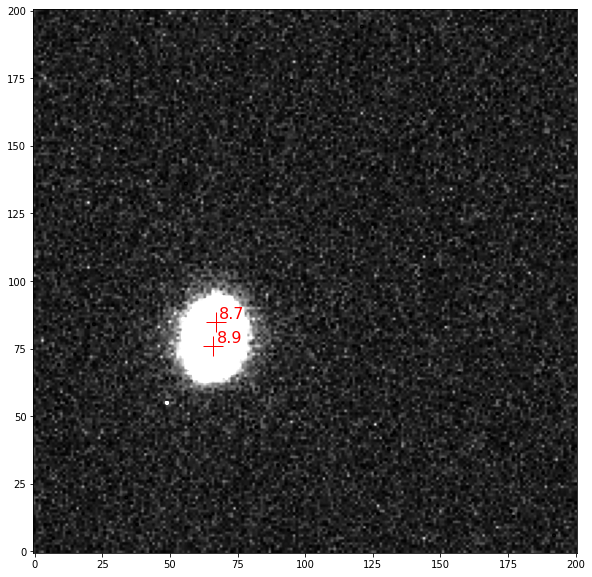

In [45]:
#@title Display Surface and PSF

##########################################################

def get_image_data(img, stars, roi_size):
  infits = fits.open(img)
  hdr = dict(infits[0].header)
  wrld = WCS(infits[0].header)
  image_data = infits[0].data

  fdims = wrld.pixel_shape
  xmin = int((fdims[0]/2) - roi_size)     # zoom in on a roi around the center
  xmax = int((fdims[0]/2) + roi_size)
  ymin = int((fdims[1]/2) - roi_size)
  ymax = int((fdims[1]/2) + roi_size)

  i, j = 0, 0
  zoomed_image_data = []
  for i in range(len(image_data)):
    if i < ymin or i > ymax:
      continue
    s = image_data[i]
    new_row = []
    for j in range(len(s)):
      if j < xmin or j > xmax:
        continue
      new_row.append(image_data[i][j])
    zoomed_image_data.append(new_row)

  zoomed_stars = []                 # find new coordinates for the zoomed in stars
  for star in stars:
    label, ra, dec = star["label"], star["ra"], star["dec"]
    zoomed_star = {"label": label, "ra": ra, "dec": dec}
    skystar = SkyCoord(ra, dec, frame='fk5', unit='deg')
    stary, starx = wrld.world_to_array_index(skystar)
    star["starx"] = starx
    star["stary"] = stary
    star["labelx"] = starx + (fdims[0]/80)
    star["labely"] = stary + (fdims[1]/80) 
    zoomed_star["starx"] = starx - xmin
    zoomed_star["stary"] = stary - ymin
    zoomed_star["labelx"] = starx - xmin + (roi_size/80)
    zoomed_star["labely"] = stary - ymin + (roi_size/80)

    if label == "12.42":
      zoomed_star["labelx"] = starx - xmin - 5
      zoomed_star["labely"] = stary - ymin - 5

    zoomed_stars.append(zoomed_star)

  return(image_data, zoomed_image_data, zoomed_stars)

##########################################################

def display_image(image_data, stars):
  norm = ImageNormalize(image_data, interval=ZScaleInterval(), stretch=SquaredStretch())
  fig = plt.figure(figsize=(15,10))
  ax = fig.add_subplot(111)
  plt.imshow(image_data, norm=norm, origin='lower', cmap='Greys_r', interpolation=None)

  for star in stars:
    label = star["label"]
    starx, stary = star["starx"], star["stary"]
    labelx, labely = star["labelx"], star["labely"]
    ax.plot(starx, stary, marker='+',color='red', ms=20)
    ax.text(labelx, labely, label, color = 'red', fontsize=16)

##########################################################

def get_roi_data(starx, stary, image_data, x_roi, y_roi):
  x, y = int(starx), int(stary)
  x_extent, y_extent = 2*x_roi, 2*y_roi

  x_vals, y_vals, z_vals = [], [], []
  for j in range(len(image_data)):
    if j >= y-y_roi and j <= y+y_roi:
      row = image_data[j]
      for i in range(len(row)):
        if i >= x-x_roi and i <= x+x_roi:
          x_vals.append(i)
          y_vals.append(j)
          z_vals.append(image_data[j][i])

  return(x_vals, y_vals, z_vals)

###############################################################

roi_size = 100  # Smaller roi --> less laggy surface

image_data, zoomed_image_data, zoomed_stars = get_image_data(img, stars, roi_size)
display_image(zoomed_image_data, zoomed_stars)

roi_size = 50

x, y = stars[0]["starx"], stars[0]["stary"]
x_vals, y_vals, z_vals = get_roi_data(x, y, image_data, roi_size, roi_size)

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
bk.output_notebook()
source = ColumnDataSource(data=dict(x=x_vals, y=y_vals, z=z_vals))
surface = Surface3d(x="x", y="y", z="z", data_source=source, width=600, height=600)

bk.show(surface)
